<a href="https://colab.research.google.com/github/knobs-dials/wetsuite-dev/blob/main/notebooks/intro/using_dataset_cvdr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# (only) in colab, run this first to install wetsuite from (the most recent) source.   For your own setup, see wetsuite's install guidelines.
!pip3 install -U --no-cache-dir --quiet https://github.com/knobs-dials/wetsuite-dev/archive/refs/heads/main.zip

## Purpose of this notebook

Explore what is in the CVDR dataset(s), and what you could easily do with it. 

In [1]:
import collections, random, pprint

import wetsuite.helpers.etree
import wetsuite.helpers.net
import wetsuite.datasets
import wetsuite.helpers.koop_parse


## XML form

### Quick sidetrack: Raw document

Before we get to more convenience, let's get a feel for what is in there.


In [25]:
url = 'https://repository.officiele-overheidspublicaties.nl/CVDR/CVDR621050/2/xml/CVDR621050_2.xml' # a cherry-picked example
example_tree = wetsuite.helpers.etree.fromstring( wetsuite.helpers.net.download( url ) ) # fetch and parse

# for ease of walking, and consistency with other tutorials, let's strip namespaces
example_tree = wetsuite.helpers.etree.strip_namespace( example_tree )

# print the document mostly as we fetched it, reindented to make the structure more visual 
#   (note: you shouldn't reindent during data processing because it changes the document)
print( wetsuite.helpers.etree.debug_pretty( example_tree, reindent=True ) ) 

<cvdr schemaLocation="http://standaarden.overheid.nl/cvdr/terms/  http://decentrale.regelgeving.overheid.nl/cvdr/xsd/cvdr.xsd">
  <!--export0.92-->
  <meta>
    <owmskern>
      <identifier>CVDR621050_2</identifier>
      <title>Verordening van de raad, het college van burgemeester en wethouders en de burgemeester over de taken en bevoegdheden van de commissie bezwaarschriften (Verordening commissie bezwaarschriften Heemstede 2022)</title>
      <language>nl</language>
      <type scheme="overheid:Informatietype">regeling</type>
      <creator scheme="overheid:Gemeente">Heemstede</creator>
      <modified>2022-07-16</modified>
    </owmskern>
    <owmsmantel>
      <isFormatOf resourceIdentifier="https://zoek.officielebekendmakingen.nl/gmb-2022-324550">gmb-2022-324550</isFormatOf>
      <alternative>Verordening commissie bezwaarschriften Heemstede 2022</alternative>
      <source resourceIdentifier="1.0:c:BWBR0005537&amp;artikel=7%3A13&amp;g=2019-01-01">artikel 7:13 van de Algemene wet

In [26]:
# Okay, maybe let's look at just the body contents.
print( wetsuite.helpers.etree.debug_pretty( example_tree.find('body') ) )

<body>
  <intitule>Verordening van de raad, het college van burgemeester en wethouders en de burgemeester over de taken en bevoegdheden van de commissie bezwaarschriften (Verordening commissie bezwaarschriften Heemstede 2022)</intitule>
  <regeling>
    <aanhef>
      <preambule>
        <al>De raad, het college en de burgemeester van de gemeente Heemstede;</al>
        <al>ieder voor zover het hun bevoegdheden betreft;</al>
        <al>gelezen het voorstel van het college van 17 november 2015, 18 december 2018 en 10 mei 2022;</al>
        <al>gelet op artikel 7:13 van de Algemene wet bestuursrecht (Awb);</al>
        <al/>
        <al>besluiten vast te stellen de volgende verordening:</al>
        <al/>
        <al>Verordening commissie bezwaarschriften Heemstede 2022</al>
      </preambule>
    </aanhef>
    <regeling-tekst>
      <artikel>
        <kop>
          <label>Artikel</label>
          <nr>1</nr>
          <titel>Begripsbepalingen</titel>
        </kop>
        <al>In deze

### Back on track: Metadata

The metadata header contains various useful things, but it's in a few different places, and it is varied in structure.

A lot of items are key-value, including:
* owmskern's    `<identifier>CVDR641872_2</identifier>`
* owmskern's    `<title>Nadere regels jeugdhulp gemeente Pijnacker-Nootdorp 2020</title>`
* owmskern's    `<language>nl</language>`
* owmskern's    `<modified>2022-02-17</modified>`
* owmsmantel's  `<alternative>Nadere regels jeugdhulp gemeente Pijnacker-Nootdorp 2020</alternative>`
* owmsmantel's  `<subject>maatschappelijke zorg en welzijn</subject>`
* owmsmantel's  `<issued>2022-02-08</issued>`
* owmsmantel's  `<rights>De tekst in dit document is vrij van auteursrecht en databankrecht</rights>`

However, it's actually allowed to have attributes, including e.g.:
* owmskern's    `<type scheme="overheid:Informatietype">regeling</type>  (except there's no variation in that value anyway)`
* owmskern's    `<creator scheme="overheid:Gemeente">Pijnacker-Nootdorp</creator>`
* owmsmantel's  `<isRatifiedBy scheme="overheid:BestuursorgaanGemeente">college van burgemeester en wethouders</isRatifiedBy>`
* owmsmantel's  `<isFormatOf resourceIdentifier="https://zoek.officielebekendmakingen.nl/gmb-2022-66747">gmb-2022-66747</isFormatOf>`
* owmsmantel's  `<source resourceIdentifier="https://lokaleregelgeving.overheid.nl/CVDR641839">Verordening jeugdhulp gemeente Pijnacker-Nootdorp 2020</source>`

With the default `flatten=False` you will get structured data close to the original XML:

        'creator': [{'attr': {'scheme': 'overheid:Gemeente'}, 'text': 'Zuidplas'}],

Yet if you just want to show a person a moderately readable summary, like here,
you can use `flatten=True` to ask it to creatively smush those into a single string, 
yielding something like:

        'creator': 'Zuidplas (overheid:Gemeente)',


In [37]:
# First, let's switch to real data, from a dataset
cvdr_xml = wetsuite.datasets.load('cvdr-mostrecent-xml')

url, xml_bytes = cvdr_xml.data.random_choice() # you can re-run this until you get an interesting one.
parsed_example = wetsuite.helpers.etree.fromstring( xml_bytes )

# In flattened form, for readability
display( wetsuite.helpers.koop_parse.cvdr_meta(parsed_example, flatten=True) )

# non-flattened original, may be preferable for more structured ingest into something else
display( wetsuite.helpers.koop_parse.cvdr_meta(parsed_example, flatten=False) )   

{'identifier': 'CVDR27227_1',
 'title': 'Verordening op de heffing en de invordering van brandweerrechten 2007',
 'language': 'nl',
 'type': 'regeling (overheid:Informatietype)',
 'creator': 'Boekel (overheid:Gemeente)',
 'modified': '2018-01-23',
 'spatial': 'Boekel (overheid:Gemeente)',
 'isFormatOf': 'Weekblad Boekel & Venhorst, 03-08-2010 ()',
 'alternative': 'Verordening Brandweerrechten 2007',
 'source': 'Gemeentewet, artikel 229 (1.0:v:BWBR0005416&artikel=229)',
 'isRatifiedBy': 'gemeenteraad (overheid:BestuursorgaanGemeente)',
 'subject': 'financiën en economie',
 'issued': '2006-12-21',
 'rights': 'De tekst in dit document is vrij van auteursrecht en\n                    databankrecht',
 'inwerkingtredingDatum': '2010-08-04',
 'terugwerkendekrachtDatum': '2007-01-01',
 'betreft': 'Nieuwe regeling',
 'kenmerk': 'PD/000728',
 'gedelegeerdeRegelgeving': 'Geen',
 'redactioneleToevoeging': 'Geen'}

{'identifier': [{'text': 'CVDR27227_1', 'attr': {}}],
 'title': [{'text': 'Verordening op de heffing en de invordering van brandweerrechten 2007',
   'attr': {}}],
 'language': [{'text': 'nl', 'attr': {}}],
 'type': [{'text': 'regeling', 'attr': {'scheme': 'overheid:Informatietype'}}],
 'creator': [{'text': 'Boekel', 'attr': {'scheme': 'overheid:Gemeente'}}],
 'modified': [{'text': '2018-01-23', 'attr': {}}],
 'spatial': [{'text': 'Boekel', 'attr': {'scheme': 'overheid:Gemeente'}}],
 'isFormatOf': [{'text': 'Weekblad Boekel & Venhorst, 03-08-2010',
   'attr': {'resourceIdentifier': ''}}],
 'alternative': [{'text': 'Verordening Brandweerrechten 2007', 'attr': {}}],
 'source': [{'text': 'Gemeentewet, artikel 229',
   'attr': {'resourceIdentifier': '1.0:v:BWBR0005416&artikel=229'}}],
 'isRatifiedBy': [{'text': 'gemeenteraad',
   'attr': {'scheme': 'overheid:BestuursorgaanGemeente'}}],
 'subject': [{'text': 'financiën en economie', 'attr': {}}],
 'issued': [{'text': '2006-12-21', 'attr': {

type:                     BWB
URL-like reference:       1.0:v:BWBR0005416&artikel=229
more specific reference:  BWBR0005416
parts:                    OrderedDict([('artikel', ['229'])])
source_text:              Gemeentewet, artikel 229




### Source references,

That XML metadata also explicitly contains some source references. 
Do not expect these to be complete in the legal-basis sense,
but they can be quite useful when they are there.

While listed in the metadata above, they can stand some cleanup and interpretation
(in fact a little more than what we currently do)

In [38]:
for typ, origref, specref, parts, source_text in  wetsuite.helpers.koop_parse.cvdr_sourcerefs(parsed_example):
    msg = (f"type:                     {typ}\n"+
           f"URL-like reference:       {origref}\n"+
           f"more specific reference:  {specref}\n"+
           f"parts:                    {parts}\n"+
           f"source_text:              {source_text}\n\n")
    print(msg)

type:                     BWB
URL-like reference:       1.0:v:BWBR0005416&artikel=229
more specific reference:  BWBR0005416
parts:                    OrderedDict([('artikel', ['229'])])
source_text:              Gemeentewet, artikel 229




### Text.

If you do not care about structure, you can flatten everything into one string.

Some creativity is involved, so do not expect this to be entirely regular, or pretty

In [39]:
print( wetsuite.helpers.koop_parse.cvdr_text(parsed_example) )

Onder de naam “brandweerrechten” worden geheven:
rechten voor het gebruik overeenkomstig de bestemming van voor de openbare dienst bestemde bezittingen van de gemeentelijke brandweer of van voor de openbare dienst bestemde werken of inrichtingen die bij de gemeentelijke brandweer in beheer of in onderhoud zijn;
rechten voor het genot van door de gemeentelijke brandweer verstrekte diensten.

Geen rechten als bedoeld in het eerste lid worden geheven ter zake van:
het voorkomen, beperken en bestrijden van brand;
het beperken van brandgevaar;
het voorkomen en beperken van ongevallen bij brand;
al hetgeen met de onderdelen a, b en c verband houdt;
het beperken en bestrijden van gevaar voor mensen en dieren bij ongevallen anders dan bij brand;
de bestrijding en beperking van rampen, als bedoeld in artikel 1 van de Rampenwet en Zware Ongevallen.
Belastingplicht 
Belastingplichtig is:
degene die gebruik maakt van de bezittingen, werken of inrichtingen als bedoeld in artikel 1, eerste lid, onde

## HTML form

There is an almost-equivalent dataset in HTML form. 
Some will find this easier to ingest, though it is also a little less complete and precise than the XML.


In [43]:
cvdr_html = wetsuite.datasets.load('cvdr-mostrecent-html')

key, html_bytes = cvdr_html.data.random_choice() 

#render HTML in jupyter - we generally wouldn't
from IPython.core.display import HTML
HTML( html_bytes.decode('utf8') )

#display( html_bytes )

## (quite optional:) Diving deeper into the XML

When you want more structure than plain text, you quickly have to dive deeper, in a way specific to a data source.

This gives an overview of the structure of the text documents (in XML form) in the CVDR repository,
and some ideas of how to process that as more than flat text.


### Why do this?

**What do these XML documents actually give us?**

In terms of natural language, legal texts are fairly precise and decently structured, by merit of needing to be unambiguous. What XML can and often does add to that is grouping natural sentences into ever narrower portions, like like chapters and paragraphs, structuring lists and tables.


**What might we want to do?**

The amount you care about this structure would vary with your research question
  - e.g. to summarize the subjects mentioned, you might only care about the words and phrases in it

  - to categorize portions of a document (say policy into introduction, motivation, implementation details, or case law into claim, court judgment, etc), we may only care to distinguish) we may only care to separate section

  - You might to group adjacent paragraphs (well, alineas - there's some loss in translation here) when they belong to the same portion/argument - this would certainly be easier to do if you still have the document structure
  
  - to find the most normative statements, and extract their meaning, you care more about structure and context

  - in laws, you might very much like to keep "this text comes from from article 1, lid 4"
  

**What can we add?**

We should certainly make an effort to make typical tasks easier

It should also be pointed out that we can only do so much.
The more precise your research question the more you may have to dig into the details.

Regardless of your question, you may run into the fact that while _in theory_ this all gives you fragments of well-defined and self-contained text,
in practice things are messier. People are quite pragmatic and gloss over a lot (consider e.g. how you would interpret the list in artikel 2 lid 2 in the first example below), but code tends to be stupidly literal.

So let's look at some documents, and see what is necessary.

#### Some side questions - container of this container (you can skip this)

First question: does that structure always looks like that, or does it act more like a free-form document in the sense of allowing whatever you put in?

There is an XML schema (e.g. [included in the following PDF; TODO: find in XML form](https://www.koopoverheid.nl/binaries/koop/documenten/instructies/2017/10/23/cvdr-handleiding-deel-6-deel-6-metadata-xml-schema-en-webservices/IPM_dr_4_0_deel_6-Metadata_XML-schema_Webservices-1.pdf)) that should help answer that (if you don't know, a schema settles things like which elements (and attributes) are allowed to appear in the context of which others). 
It's long and seems detailed, and is technically useful, but also not very readable, and it turns out it's relatively forgiving in which elements are used to narrow down, and how many. 
Let's show rather than tell:

From the above, we have the question of how consistent the parts under `regeling` are - are things always nested the same way, or not?

To find out, let's see the path you have to walk *between* `regeling` to each child node, to get a feel of both common and uncommon nesting.
And let's do that to a _lot_ of documents.

In [44]:
cvdr_xml = wetsuite.datasets.load('cvdr-mostrecent-xml')

cvdr_parsed = [] # list of (source url, etree object) tuples

cvdr_urls = cvdr_xml.data.keys()
cvdr_urls_subset = random.sample(cvdr_urls, 20000) # 160K is a bit much in RAM, and a sizeable random selection should be enough

for cvdr_url in cvdr_urls_subset: 
    bytestring = cvdr_xml.data.get( cvdr_url )
    tree = wetsuite.helpers.etree.fromstring( bytestring )
    tree = wetsuite.helpers.etree.strip_namespace( tree )
    cvdr_parsed.append( (url, tree) )

In [21]:
# Run the path counter.__name__
#  First questions: how common are each of the broad parts in the regeling?
count_paths = collections.defaultdict( int )

for url, tree in cvdr_parsed:
    # We stop two-deep to only get the direct things under regeling, to avoid verbosity
    for path, count in wetsuite.helpers.etree.path_count( tree.find('body/regeling'), max_depth=2 ).items():
        count_paths[path] += count

for path, count in sorted( count_paths.items() ):
    print( '%6d  %s'%(count,path))

 20000  regeling
 20000  regeling/aanhef
  8806  regeling/bijlage
  5535  regeling/nota-toelichting
     2  regeling/officiele-inhoudsopgave
 13749  regeling/regeling-sluiting
 20000  regeling/regeling-tekst


In [22]:
# Out of curiosity, what's in the aanhef?
count_paths = collections.defaultdict( int )
for url, tree in cvdr_parsed:
    for path, count in wetsuite.helpers.etree.path_count( tree.find('body/regeling/aanhef'), max_depth=4 ).items():
        count_paths[path] += count

for path, count in sorted( count_paths.items() ):
    print( '%6d  %s'%(count,path))

 20000  aanhef
   849  aanhef/afkondiging
  3530  aanhef/afkondiging/al
    13  aanhef/afkondiging/al/cursief
    14  aanhef/afkondiging/al/extref
     1  aanhef/afkondiging/al/noot
    48  aanhef/afkondiging/al/onderstreept
     3  aanhef/afkondiging/al/plaatje
     6  aanhef/afkondiging/al/sup
   771  aanhef/afkondiging/al/vet
    41  aanhef/afkondiging/lijst
   115  aanhef/afkondiging/lijst/li
     2  aanhef/context
     2  aanhef/context/context.lijst
     2  aanhef/context/context.lijst/li
 19997  aanhef/preambule
162585  aanhef/preambule/al
  1748  aanhef/preambule/al/cursief
  1608  aanhef/preambule/al/extref
     6  aanhef/preambule/al/inf
    33  aanhef/preambule/al/noot
   582  aanhef/preambule/al/onderstreept
   171  aanhef/preambule/al/plaatje
   148  aanhef/preambule/al/sup
 20398  aanhef/preambule/al/vet
     5  aanhef/preambule/kop
     6  aanhef/preambule/kop/label
  5930  aanhef/preambule/lijst
 18150  aanhef/preambule/lijst/li
    71  aanhef/wie
     8  aanhef/wij


So broadly, the body seems to contain
* `intitule`
* `regeling`
  * `aanhef` (apparently always there), mostly `preambule` text
  * `regeling-tekst` is the main text (always there), more on that below
  * `regeling-sluiting` is some formalities (usually there)
  * `bijlage` may be additional useful stuff (there half the time)

#### The main question - body structure

Our initial question was about the paths under `regeling-tekst`

In [23]:
count_paths = collections.defaultdict( int )

for url, tree in cvdr_parsed:
    for path, count in wetsuite.helpers.etree.path_count( tree.find('body/regeling/regeling-tekst') ).items():
        count_paths[path] += count

for path, count in sorted( count_paths.items() ):
    if count > 100:
        print( '%6d  %s'%(count,path))

 20000  regeling-tekst
   168  regeling-tekst/afdeling/artikel
   119  regeling-tekst/afdeling/artikel/al
   168  regeling-tekst/afdeling/artikel/kop
   167  regeling-tekst/afdeling/artikel/kop/label
   192  regeling-tekst/afdeling/artikel/lid
   207  regeling-tekst/afdeling/artikel/lid/al
   192  regeling-tekst/afdeling/artikel/lid/lidnr
   152  regeling-tekst/afdeling/artikel/lijst/li
   153  regeling-tekst/afdeling/artikel/lijst/li/al
115847  regeling-tekst/artikel
307139  regeling-tekst/artikel/al
  9951  regeling-tekst/artikel/al/cursief
   336  regeling-tekst/artikel/al/cursief/onderstreept
   122  regeling-tekst/artikel/al/cursief/vet
  1346  regeling-tekst/artikel/al/extref
   277  regeling-tekst/artikel/al/noot
   289  regeling-tekst/artikel/al/noot/noot.al
   277  regeling-tekst/artikel/al/noot/noot.nr
  4548  regeling-tekst/artikel/al/onderstreept
   608  regeling-tekst/artikel/al/plaatje
   608  regeling-tekst/artikel/al/plaatje/illustratie
   588  regeling-tekst/artikel/al

#### Say you want to process this text in a more structured way that completely flat

What if we selected all the `<al>` tags and extracted their `.text` ?

Let's use a helper that visualizes a selection within an etree, to see if our selection makes sense
(note: this works only if we're in an ipython style notebook)


In [30]:
wetsuite.helpers.notebook.etree_visualize_selection( 
    example_tree, 
    'body/regeling/regeling-tekst//al', # single slash is directly under, double slash is anywhere under. See XPath syntax
    reindent=True, mark_subtree=True
)

#### What about the structure?

the above is not quite there. It's nicely selective, but also missing all structure.

We are often also interested to pick out the structure it's from.

If you're used to both this sort of legal text, and XML, 
then your eyes may read the XML and glide over to check the `artikel/nr` and `lid/lidnr` for the part you want,
but doing such a 'the part I'm interested in' lookup in code on just the XML is easily quite awkward.

So let's attempt to make that simpler.

The idea behind the below here is to create an inbetween form that _contains_ all the detail, 
but in a structured way we can process more easily.

In [34]:
more_complex_example_tree = wetsuite.helpers.etree.fromstring( 
    wetsuite.helpers.net.download( 'https://repository.officiele-overheidspublicaties.nl/CVDR/CVDR11313/52/xml/CVDR11313_52.xml' )
)

alinea_dicts = wetsuite.helpers.koop_parse.alineas_with_selective_path( more_complex_example_tree, start_at_path='body/regeling/regeling-tekst' )

/usr/local/lib/python3.8/dist-packages/wetsuite/helpers/koop_parse.py:930: UserWarning: The behaviour of alineas_with_selective_path() is not fully decided, and may still change
  warnings.warn('The behaviour of alineas_with_selective_path() is not fully decided, and may still change')


In [36]:
# alineas_with_selective_path returned a dict, one for each al tag, detailing where it came from. They look like:
for alinea_dict in alinea_dicts[:10]: # show just a handful, let's not spam too much
    print('-'*80)
    pprint.pprint( alinea_dict )

--------------------------------------------------------------------------------
{'merged': {'artikellabel': 'Artikel',
            'artikelnr': '1:1',
            'artikeltitel': 'Begripsomschrijvingen',
            'hoofdstuklabel': 'Hoofdstuk',
            'hoofdstuknr': '1',
            'hoofdstuktitel': 'Algemene bepalingen'},
 'parts': [{'hoofdstuklabel': 'Hoofdstuk',
            'hoofdstuknr': '1',
            'hoofdstuktitel': 'Algemene bepalingen',
            'what': 'hoofdstuk'},
           {'artikellabel': 'Artikel',
            'artikelnr': '1:1',
            'artikeltitel': 'Begripsomschrijvingen',
            'what': 'artikel'}],
 'path': '/cvdr/body/regeling/regeling-tekst/hoofdstuk[1]/artikel[1]/al',
 'text-flat': 'In deze verordening wordt verstaan dan wel mede verstaan onder:'}
--------------------------------------------------------------------------------
{'merged': {'artikellabel': 'Artikel',
            'artikelnr': '1:1',
            'artikeltitel': 'Begripsomsc

Okay, that's *****extremely***** verbose, but you can start to see how you can pick out, for example, just the text:

In [38]:

for alinea_dict in alinea_dicts[:10]:
    pprint.pprint( alinea_dict['text-flat'] )

'In deze verordening wordt verstaan dan wel mede verstaan onder:'
'a.'
'Weg:'
''
''
'1.'
('de weg, als bedoeld in artikel 1, eerste lid, onder b, van de '
 'Wegenverkeerswet 1994, alsmede de daaraan liggende en als zodanig aangeduide '
 'parkeerterreinen;')
''
'2.'
('de - al dan niet met enige beperking - voor het publiek toegankelijke '
 'pleinen en open plaatsen, parken, plantsoenen, speelweiden, bossen en andere '
 'natuurterreinen, ijsvlakten en aanlegplaatsen voor vaartuigen;')


More interestingly, though, data like that makes it easier to express things like
**"please merge anything that mentions being in the same hoofdstuk and afdeling"**

To this end, there is the `merge_alinea_data()` function
* merge everything that has the same values for the same structural elements, down to a specified level,
  because the default is 'down to lid', this mostly just merges flattening lists and tables, and join alineas if there are multiple)
  and in this particular document means "if it has the same values for hoofdstuk, artikel, and lid"

this is controllable, TODO: make easier, and then make an example how
- mentiones the larger structural elements that flat text belongs to


In [59]:
# for how, ignore _how_ to specify these, just note that you _can_
merge_on  = {
    'hoofdstuk':'hoofdstuknr',
    'afdeling':'afdelingnr',
    'paragraaf':'paragraafnr', # e.g. remove this one to get larger chunks of text, still split into afdeling
}

for where, text_fragments in wetsuite.helpers.koop_parse.merge_alinea_data( alinea_dicts, if_same=merge_on ):
    print(f'======================= {where} =======================')
    #print('\n'.join(text_fragments))
    pprint.pprint( text_fragments ) # the text
    print()


======================= [('hoofdstuk', '1')] =======================
['In deze verordening wordt verstaan dan wel mede verstaan onder:',
 'a.',
 'Weg:',
 '',
 '',
 '1.',
 'de weg, als bedoeld in artikel 1, eerste lid, onder b, van de '
 'Wegenverkeerswet 1994, alsmede de daaraan liggende en als zodanig aangeduide '
 'parkeerterreinen;',
 '',
 '2.',
 'de - al dan niet met enige beperking - voor het publiek toegankelijke '
 'pleinen en open plaatsen, parken, plantsoenen, speelweiden, bossen en andere '
 'natuurterreinen, ijsvlakten en aanlegplaatsen voor vaartuigen;',
 '',
 '3.',
 'de voor het publiek toegankelijke stoepen, trappen, portieken, gangen, '
 'passages en galerijen, die uitsluitend tot voor bewoning in gebruik zijnde '
 'ruimte toegang geven en niet afsluitbaar zijn;',
 '',
 '4.',
 'andere voor het publiek toegankelijke, al dan niet afsluitbare stoepen, '
 'trappen, portieken, gangen, passages en galerijen; de afsluitbare alleen '
 'gedurende de tijd dat zij niet door of vanw

##### Do somehting useful with that

If something has many sections, it may be useful to see what each section deals with

This is probably a task for something clever like topic modelling, 
but before we get distracted by that, let's just do some dumb counting to make word clouds.


[('hoofdstuk', '1')]


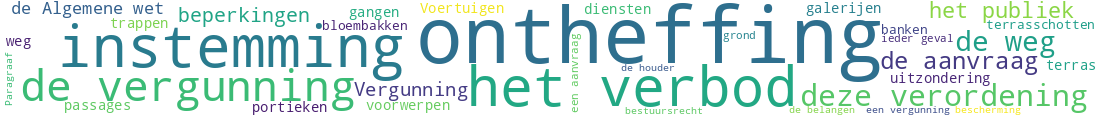

[('hoofdstuk', ''), ('afdeling', '2')]


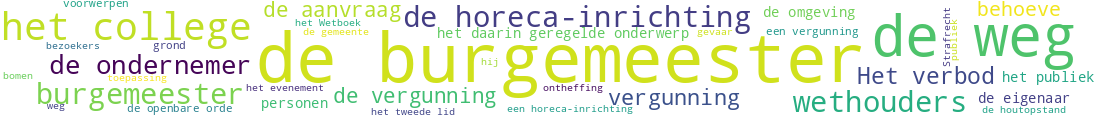

[('hoofdstuk', ''), ('afdeling', '2'), ('afdeling', '19')]


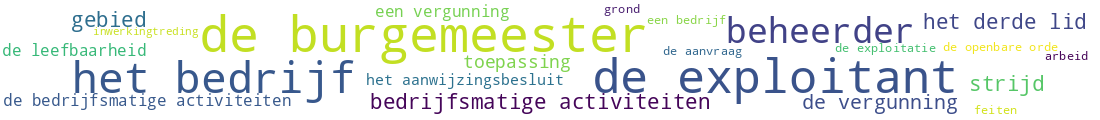

[('hoofdstuk', ''), ('afdeling', '3')]


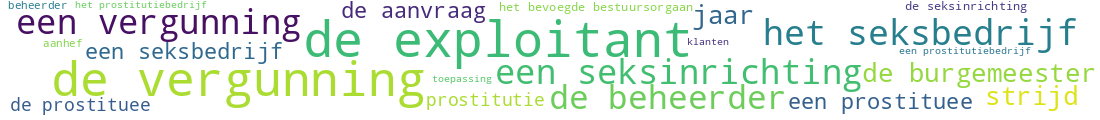

[('hoofdstuk', ''), ('afdeling', '4')]


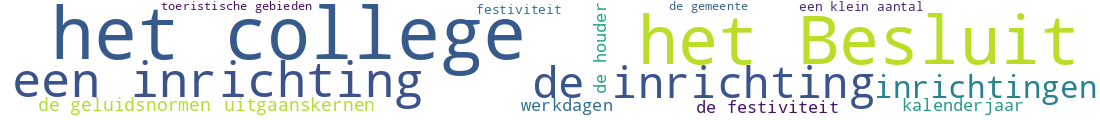

[('hoofdstuk', ''), ('afdeling', '5')]


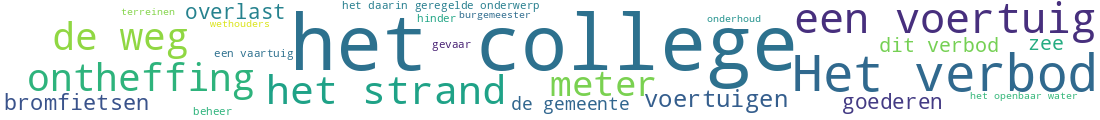

[('hoofdstuk', ''), ('afdeling', '6')]


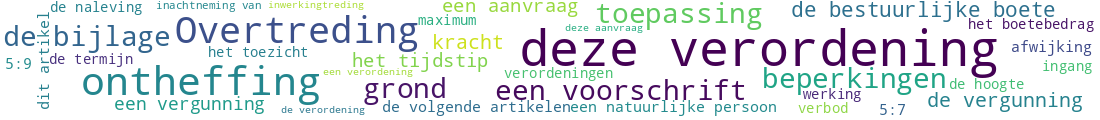

In [64]:
import wetsuite.helpers.koop_parse
import wetsuite.extras.word_cloud
import wetsuite.helpers.spacy

from importlib import reload
reload(wetsuite.extras.word_cloud)
reload(wetsuite.helpers.spacy)

stopwords = wetsuite.extras.word_cloud.stopwords_nl + ( # some extra words to ignore
    'Artikel','artikel','de artikelen',  'eerste lid', 'het eerste lid', 'tweede lid',  'wet', 'de Wet', 'Het',  'zij',
    'gebruik', 'type', 'gehore', 'het belang', 'weken', 'maanden', 'uur',
)

for meta_ary, text_ary in wetsuite.helpers.koop_parse.merge_alinea_data( alinea_dicts, if_same={'hoofdstuk':'hoofdstuknr', 'afdeling':'afdelingnr',}  ):
    print( meta_ary )
    text = ' '.join( text_ary )
    nc = wetsuite.helpers.spacy.nl_noun_chunks(text)
    #print(nc)
    #tokens = wetsuite.extras.word_cloud.simple_tokenize(text)
    counts = wetsuite.extras.word_cloud.count_case_insensitive( nc, stopwords=stopwords )
    im = wetsuite.extras.word_cloud.wordcloud_from_freqs( counts, 1100, 120 )
    display( im )

##### Other examples you may wish to try
* Example with afdeling
  * https://repository.officiele-overheidspublicaties.nl/CVDR/CVDR386553/5/xml/CVDR386553_5.xml


* Example with afdeling, hoofdstuk, paragraaf -- which also seems to (wildly) abuse them as each other
  * https://repository.officiele-overheidspublicaties.nl/CVDR/CVDR11313/52/xml/CVDR11313_52.xml


* example with titeldeel, afdeling (and some )
  * https://repository.officiele-overheidspublicaties.nl/CVDR/CVDR142369/1/xml/142369_1.xml


* Example with nested afdelingen - e.g. regeling-tekst/hoofdstuk/afdeling/paragraaf/afdeling/artikel/kop/titel/vet
  * https://repository.officiele-overheidspublicaties.nl/CVDR/CVDR297855/7/xml/CVDR297855_7.xml

